In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import itertools
import json
import os

import anndata as ad
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn
import sklearn.cluster
import torch
import tqdm
import umap
# import umap.parametric_umap

import celltrip
  

mpl.rcParams['pdf.fonttype'] = 42


2026-01-22 02:11:12.909266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [3]:
# Read data
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/ExpVal/expression.h5ad', backed=True)
np.random.seed(42)
sample_mask = np.random.rand(adata.shape[0]) < .1  # 76,855 total, REMOVE
adata = adata[sample_mask]

# Correct variables
adata.obs['age_orig'] = adata.obs['age']
adata.obs['age'] = adata.obs['age'].apply(lambda x: {  # Translate ages (TODO: Verify that this is correct)
    k: v for k, v in zip(
        ['E87', 'E96', 'E101', 'E104', 'E112', 'E127', 'E150', 'E155'],
        (85, 95, 100, 105, 110, 125, 145, 155))}[x])
adata.obs['subtype_orig'] = adata.obs['subtype']
adata.obs['subtype'] = adata.obs['subtype'].map(lambda s: ' '.join(s.split(' ')[:2]), na_action='ignore')  # Shorten subtypes

# Normalize data for visualization
sim_data = adata.X[:]
sim_data_norm = 10_000 * sim_data / sim_data.sum(axis=1)

# Load manager
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/ExpVal-251120', 800
manager = celltrip.manager.BasicManager(
    policy_fname=f'{prefix}-{training_step:04}.weights',
    preprocessing_fname=f'{prefix}.pre',
    mask_fname=f'{prefix}.mask',
    device='cuda')
manager.set_modalities([adata], suppress_warning=True)


/tmp/ipykernel_10659/1132682663.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['age_orig'] = adata.obs['age']


# Simulate

In [4]:
# # Simulate to steady state
# manager.reset_env()
# manager.simulate(skip_time=512., impute=False)
# manager.save_state('steady')
# steady_gex, = manager.get_state()

## Visualize

In [5]:
# # Reduce observed
# # red = umap.parametric_umap.UMAP(
# red = umap.UMAP(
#     # low_memory=True,
#     # random_state=42,
# )
# sim_data_embed = red.fit_transform(sim_data_norm)
# sim_data_embed = pd.DataFrame(sim_data_embed, index=adata.obs_names, columns=[f'UMAP-{i+1}' for i in range(sim_data_embed.shape[1])])
# sim_data_embed['subtype'] = adata.obs['subtype']
# sim_data_embed['sample'] = adata.obs['sample']
# sim_data_embed['age'] = adata.obs['age']
# sim_data_embed['source'] = 'Observed'

# # Reduce CellTRIP
# steady_gex_embed = red.transform(steady_gex)  # np.concat([sim_data, steady_gex], axis=0)
# steady_gex_embed = pd.DataFrame(steady_gex_embed, index=adata.obs_names, columns=[f'UMAP-{i+1}' for i in range(steady_gex_embed.shape[1])])
# steady_gex_embed['subtype'] = adata.obs['subtype']
# steady_gex_embed['sample'] = adata.obs['sample']
# steady_gex_embed['age'] = adata.obs['age']
# steady_gex_embed['source'] = 'CellTRIP'

In [6]:
# # Concatenate
# concat_embed = pd.concat([sim_data_embed, steady_gex_embed], axis=0)

# # Plot observed vs. CellTRIP
# fig, ax = plt.subplots(figsize=(6, 6))
# var = 'age'  # 'subtype'

# sns.scatterplot(concat_embed, x='UMAP-1', y='UMAP-2', hue=var, style='source', s=5, legend=True, ax=ax)
# sns.despine(ax=ax)
# # Annotate
# # var_means = concat_embed.groupby(var, observed=True)[['UMAP-0', 'UMAP-1']].median()
# # for var, r in var_means.iterrows():
# #     ax.text(*r.to_numpy(), var, ha='center', va='center', fontsize='xx-small', transform=ax.transData)

# # Save
# fig.savefig('../plots/expval/age_umap.pdf')

# Knockdown

In [7]:
# Parameters
samples_to_perturb = adata.obs['sample'].unique()

# Manual assignment
# genes_to_perturb = (
#     'RAPGEF4', 'CHD8',  # Experimental genes for neuronal maturation
#     'MEIS2', 'NFIA', 'NFIB',  # Known TFs for neuronal maturation
# )

# Permutations
n_samples = 1_000
n_samples_per_gene = 3
# Generate permutations
np.random.seed(42)
n_genes = adata.shape[1]
permutation_matrix = np.zeros((n_samples, n_genes), dtype=bool)
idx = np.random.rand(*permutation_matrix.shape).argpartition(-n_samples_per_gene, axis=0)[-n_samples_per_gene:]  # Select `n_samples_per_gene` for each gene
permutation_matrix[idx, np.indices(idx.shape)[1]] = True
# CLI
est_time = len(samples_to_perturb) * (25 + 4 * n_samples) / 60**2  # timepoints * (25 sec/init + 4 sec/pert * n_samples)
print(f'Perturbation will take ~{est_time:.2f}h with ~{n_genes*n_samples_per_gene/n_samples:.0f} genes per permutation')
# Final gene lists
genes_to_perturb = [tuple(adata.var_names[r].tolist()) for r in permutation_matrix]


Perturbation will take ~11.18h with ~47 genes per permutation


In [8]:
# # Initialize
# pert_results = []
# for sample in samples_to_perturb:
#     # Filter adata
#     adata_sample = adata[adata.obs['sample']==sample]
#     sample_age = adata_sample.obs['age'].iloc[0]
#     manager.set_modalities([adata_sample], suppress_warning=True)
#     identifier = f'{sample_age} ({sample})'

#     # Simulate to steady state
#     print(f'Simulating sample {sample} of age {sample_age}...')
#     manager.reset_env()
#     manager.simulate(skip_time=512., impute=False)
#     manager.save_state('steady')
#     steady_gex, = manager.get_state()

#     # Get control
#     time, states = manager.simulate_perturbation(skip_time=512., time=128.)
#     control_gex, = manager.get_state()

#     # Revert to previous state
#     manager.load_state('steady')
#     manager.clear_perturbations()

#     # Perturb chosen genes
#     for gene in tqdm.tqdm(genes_to_perturb):
#         # Simulate perturbation
#         # print(f'Perturbing gene(s) {gene}...')
#         gene = (gene,) if isinstance(gene, str) else gene  # Always list-like
#         manager.add_perturbation(gene, modality=0, feature_targets=0)
#         time, states = manager.simulate_perturbation(skip_time=512., time=128., progress_bar=False, impute=False)
#         knocked_gex, = manager.get_state()

#         # Get statistics
#         diff = pd.DataFrame(index=adata_sample.obs_names)
#         diff['subtype'] = adata_sample.obs['subtype']
#         diff['Steady GES'] = np.sqrt(np.square(knocked_gex - steady_gex).sum(axis=1))
#         diff['Control GES'] = np.sqrt(np.square(knocked_gex - control_gex).sum(axis=1))
#         diff_means = diff.groupby('subtype', observed=True).mean()
#         for subtype in ['All'] + adata_sample.obs['subtype'].unique().tolist():
#             if subtype == 'All': diff_results = diff.drop(columns=['subtype']).mean(axis=0).to_dict()
#             else: diff_results = diff_means.loc[subtype].to_dict()
#             pert_results.append({
#                 'Identifier': identifier,
#                 'Sample': sample,
#                 'Age': sample_age,
#                 'Gene': gene,
#                 'Subtype': subtype,
#                 **diff_results})

#         # Revert to previous state
#         manager.load_state('steady')
#         manager.clear_perturbations()

# # Convert to DataFrame and save
# sort_order = ['Age', 'Sample', 'Gene', 'Subtype']
# pert_results = pd.DataFrame(pert_results).sort_values(sort_order)
# pert_results.to_csv('../plots/expval/perm_knockdown.csv')

In [9]:
# Load results
pert_results = pd.read_csv('../plots/expval/perm_knockdown.csv', index_col=0)

In [10]:
# # Compute gene effect sizes
# ges = []
# df = pert_results.copy()  # Just overwrite to save writes
# df['Total'] = df['Gene'].apply(len)
# for gene in tqdm.tqdm(adata.var_names):
#     # Precompute
#     df['Present'] = df['Gene'].apply(lambda l: gene in l)
#     df['Raw Weight'] = df['Present'] / df['Total']

#     def compute_scores(df):
#         # Compute scores
#         df['Weight'] = df['Raw Weight'] / df['Raw Weight'].sum()
#         gene_score = (df['Weight'] * df['Steady GES']).sum()
#         reliability = df['Raw Weight'].sum()
#         # df['Effect Size'] = gene_score
#         # df['Reliability'] = reliability
#         return pd.DataFrame(pd.DataFrame([{'Gene': gene, 'Effect Size': gene_score, 'Reliability': reliability}]))

#     ges.append(
#         df.groupby(['Subtype', 'Sample', 'Age'])
#         .apply(compute_scores, include_groups=False)
#         .reset_index().drop(columns='level_3'))

#     # Limit to subtype
#     # for subtype, (sample, age) in itertools.product(
#     #     pert_results['Subtype'].unique(),
#     #     pert_results.apply(lambda r: (r['Sample'], r['Age']), axis=1).unique(),
#     # ):
#     #     df['Subtype Weight'] = df['Raw Weight']
#     #     # Filter
#     #     inverse_mask = df['Subtype']!=subtype
#     #     inverse_mask += df['Sample']!=sample
#     #     inverse_mask += df['Age']!=age
#     #     if np.sum(~inverse_mask) == 0: continue  # Skip if none
#     #     df.loc[inverse_mask, 'Subtype Weight'] = 0

#     #     # Compute scores
#     #     df['Weight'] = df['Subtype Weight'] / df['Subtype Weight'].sum()
#     #     gene_score = (df['Weight'] * df['Steady GES']).sum()
#     #     reliability = df['Subtype Weight'].sum()

#     #     # Record
#     #     ges.append({
#     #         'Gene': gene,
#     #         'Subtype': subtype,
#     #         'Identifier': f'{age} ({sample})',
#     #         'Sample': sample,
#     #         'Age': age,
#     #         'Effect Size': gene_score,
#     #         'Reliability': reliability,
#     #     })

# # Postprocess and save
# # ges = pd.DataFrame(ges)
# ges = pd.concat(ges, axis=0)
# ges.to_csv('../plots/expval/ges.csv')


In [11]:
# Load results
ges = pd.read_csv('../plots/expval/ges.csv', index_col=0)

In [12]:
# Compute percentiles
def compute_percentile(df):
    df = df.sort_values('Effect Size', ascending=False)
    df['Rank'] = np.arange(len(df))+1
    df['Quantile'] = 1 - (df['Rank']-1) / (len(df)-1)
    df['Percentile'] = 100 * df['Quantile']
    return df
ges = ges.groupby('Subtype').apply(compute_percentile, include_groups=False)
ges = ges.reset_index().drop(columns='level_1')

In [13]:
# df = ges.set_index('Gene').loc[['RAPGEF4', 'CHD8', 'NFIA', 'NFIB', 'MEIS2']]
# ges.loc[ges['Percentile'] > 80].groupby('Gene').size().sort_values(ascending=False)
# df.loc[df['Percentile'] > 90]
# df.loc[df['Percentile'] > 90].loc['RAPGEF4']
# df.loc[df['Percentile'] > 90].loc['CHD8']
# df.loc[df['Percentile'] > 90].loc['MEIS2']
ges.loc[ges['Subtype']=='ExN L2-3']

,Subtype,Sample,Age,Gene,Effect Size,Reliability,Rank,Quantile,Percentile
751632,ExN L2-3,10,155,C16H17orf99,345.946746,0.006021,1,1.000000,100.000000
751633,ExN L2-3,10,155,SLC35A3,345.853952,0.006085,2,0.999994,99.999361
751634,ExN L2-3,10,155,GNG11,345.796630,0.006126,3,0.999987,99.998723
751635,ExN L2-3,10,155,PPM1L,345.645617,0.006235,4,0.999981,99.998084
751636,ExN L2-3,10,155,HSD11B2,345.625839,0.006249,5,0.999974,99.997446
...,...,...,...,...,...,...,...,...,...
908217,ExN L2-3,8,145,ASB3,221.150855,0.006102,156586,0.000026,0.002554
908218,ExN L2-3,6,125,STK10,220.945743,0.005410,156587,0.000019,0.001916
908219,ExN L2-3,6,125,MRPL37,220.450118,0.006085,156588,0.000013,0.001277
908220,ExN L2-3,6,125,ASB3,220.423335,0.006102,156589,0.000006,0.000639


In [14]:
# Make heatmap for genes x age
df = (
    ges.loc[
        ges['Subtype'].str.startswith('ExN'),
        ['Age', 'Gene', 'Effect Size']]
    .groupby(['Age', 'Gene'])
    .mean().reset_index()
    .pivot(index='Gene', columns='Age', values='Effect Size'))
# Normalize by age
df = (df - df.to_numpy().mean(keepdims=True, axis=0)) / df.to_numpy().std(keepdims=True, axis=0)
# Filter to top 100
df = df.loc[df.mean(axis=1).sort_values(ascending=False)[:500].index]
# Shuffle
# np.random.seed(42)
# df = df.iloc[np.random.permutation(df.shape[0])]

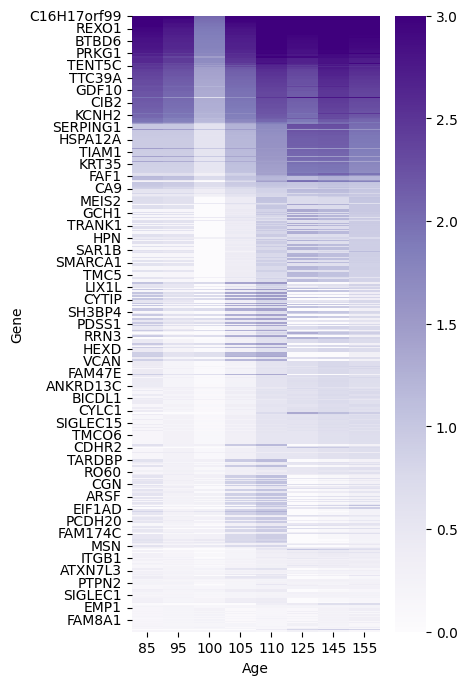

In [15]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(4, 8))
# Plot
sns.heatmap(df, vmin=0, vmax=3, cmap='Purples', ax=ax)
# Sort genes
# genes_to_show = df.mean(axis=1).sort_values(ascending=False).index[:5]
genes_to_show = df.index[::10]
df_argsort = df.index.argsort()
genes_to_show_idx = df_argsort[np.searchsorted(df.index, genes_to_show, sorter=df_argsort)] + .5
# Labels
ax.set(yticks=genes_to_show_idx, yticklabels=genes_to_show)
# Save
fig.savefig('../plots/expval/novel_genes.pdf')
fig.show()

In [109]:
# Load validation data
smart, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/ExpVal/smart_knockdown.h5ad', backed=True)

# Filter
smart = smart[smart.obs['subclass_prediction'].str.startswith('Ex').astype(bool)]

# Convert
smart = smart.copy()
smart.X = smart.X.astype(float)

In [110]:
# Get data
smart_X = smart.X[:]
# Count normalize
smart_X = 10_000 * smart_X / smart_X.sum(axis=1)
# Log
# smart_X = np.log1p(smart_X)
# Normalize
# smart_X_std = np.array(np.sqrt(smart_X.power(2).mean(axis=0) - np.square(smart_X.mean(axis=0))).reshape((1, -1)))
# smart_X_std = np.where(smart_X_std!=0, smart_X_std, 1)
# smart_X = (smart_X - smart_X.mean(axis=0)) / smart_X_std
# CSR
smart_X = smart_X.tocsr()

In [18]:
# Find compatible genes
known_var_names = adata.var_names.to_numpy()
smart_var_names = smart.var_names.to_numpy()
common_genes = np.intersect1d(known_var_names, smart_var_names)
# Filter to compatible genes
known_var_names_argsort = np.argsort(known_var_names)
smart_var_names_argsort = np.argsort(smart_var_names)
known_common_idx = known_var_names_argsort[np.searchsorted(known_var_names, common_genes, sorter=known_var_names_argsort)]
smart_common_idx = smart_var_names_argsort[np.searchsorted(smart_var_names, common_genes, sorter=smart_var_names_argsort)]
assert np.all(known_var_names[known_common_idx] == common_genes)
assert np.all(smart_var_names[smart_common_idx] == common_genes)

In [19]:
# TODO: Stratify means by cell type in smart
# TODO: Try perturbing smart cells directly
# For now, assuming that distributions are similar
# We also assume that the virus infection (NC) has additive effects, and no interaction

In [20]:
# Get means by culture and age
culture_means = {
    culture: np.asarray(
        smart_X[
            (smart.obs['acute_or_cultured'] == culture).to_numpy()]
            .mean(axis=0)).flatten()
    for culture in smart.obs['acute_or_cultured'].unique()}
culture_age_means = {
    culture: np.asarray(
        smart_X[
            (smart.obs['acute_or_cultured'] == culture).to_numpy()
            *(smart.obs['age'] == age).to_numpy()]
            .mean(axis=0)).flatten()
    for culture, age in smart.obs[['acute_or_cultured', 'age']].drop_duplicates().to_numpy()}
# Get differences
virus_diff = culture_means['shNC'] - culture_means['cultured_wo_virus_infection']
shchd8_diff = culture_means['shCHD8'] - culture_means['shNC']
total_diff = culture_means['shCHD8'] - culture_means['cultured_wo_virus_infection']

In [ ]:
# Perturb CHD8
# TODO: Replace this once we clean up adata storage for the ges generation
chd8_prediction = []
for sample in (pbar := tqdm.tqdm(adata.obs['sample'].unique())):
    # Filter adata
    adata_sample = adata[adata.obs['sample']==sample]
    sample_age = adata_sample.obs['age'].iloc[0]
    manager.set_modalities([adata_sample], suppress_warning=True)
    identifier = f'{sample_age} ({sample})'

    # Create storage file
    samp_fname = f'../plots/expval/sample_{sample}_perturbation.h5ad'
    samp_adata = ad.AnnData(obs=adata_sample.obs, var=adata_sample.var)
    samp_adata.write_h5ad(samp_fname)
    del samp_adata
    samp_h5 = h5py.File(samp_fname, 'a')

    # Simulate to steady state
    pbar.set_description(f'Simulating sample {sample} of age {sample_age}')
    manager.reset_env()
    manager.simulate(skip_time=512., impute=False, progress_bar=False)
    manager.save_state('steady')
    steady_gex, = manager.get_state()

    # Get control
    time, states = manager.simulate_perturbation(skip_time=512., time=128., progress_bar=False)
    control_gex, = manager.get_state()

    # Revert to previous state and record
    manager.load_state('steady')
    manager.clear_perturbations()
    ad.io.write_elem(samp_h5['layers'], f'Sample {sample}, Steady', steady_gex)
    ad.io.write_elem(samp_h5['layers'], f'Sample {sample}, Control', control_gex)

    # Knock CHD8
    gene = 'CHD8'
    manager.add_perturbation([gene], modality=0, feature_targets=0)
    time, states = manager.simulate_perturbation(skip_time=512., time=128., progress_bar=False, impute=False)
    knocked_gex, = manager.get_state()
    ad.io.write_elem(samp_h5['layers'], f'Sample {sample}, {gene}', knocked_gex)

    # Get statistics
    for name, gex in [('Steady', steady_gex), ('Control', control_gex), ('Knocked', knocked_gex)]:
        gex = gex[adata_sample.obs['subtype'].str.startswith('Ex')]  # Limit to Ex
        chd8_prediction.append({
            'Identifier': identifier,
            'Sample': sample,
            'Age': sample_age,
            'Gene': gene,
            'State': name,
            **{k: v for k, v in zip(adata.var_names, gex.mean(axis=0))}
        })

    # Revert to previous state
    manager.load_state('steady')
    manager.clear_perturbations()

    # Close
    samp_h5.close()

# Format
chd8_prediction = pd.DataFrame(chd8_prediction)
# celltrip.utility.processing.read_adatas(samp_fname, backed=True)[0].layers['Sample E150, Steady']

Simulating sample E150 of age 145: 100%|██████████| 10/10 [04:57<00:00, 29.74s/it] 


In [ ]:
def compute_pert(df):
    df = df.set_index('State')
    df = df.loc['Knocked'] - df.loc['Steady']
    # Note: Will throw error if multiple instances of knocked/steady are provided
    df = df.to_frame().T
    df.index = ['Perturbed']
    return df

first_cols = ['Identifier', 'Sample', 'Age', 'Gene']
chd8_pert = chd8_prediction.groupby(first_cols).apply(compute_pert, include_groups=False)
chd8_pert = chd8_pert.reset_index().drop(columns='level_4')
chd8_pert = chd8_pert.drop(columns=['Identifier', 'Sample']).groupby(['Age', 'Gene']).mean().reset_index()
chd8_pert = chd8_pert.drop(columns=['Gene'])

In [ ]:
smart.obs.groupby('age').size()

age
87     70
91      7
96     15
99      2
100    16
101    14
dtype: int64

PearsonRResult(statistic=np.float64(0.047759005608332065), pvalue=np.float64(0.06561813035764964))
PearsonRResult(statistic=np.float64(0.025060117902591963), pvalue=np.float64(0.2142959035921964))
PearsonRResult(statistic=np.float64(0.01806266903173745), pvalue=np.float64(0.2841612117191998))
PearsonRResult(statistic=np.float64(0.05829308409350416), pvalue=np.float64(0.032690015497219053))
PearsonRResult(statistic=np.float64(0.05884470557496646), pvalue=np.float64(0.031434443441932275))
PearsonRResult(statistic=np.float64(0.038613830157466236), pvalue=np.float64(0.11123162210475937))
PearsonRResult(statistic=np.float64(0.0024794650359443865), pvalue=np.float64(0.46879088129702934))
PearsonRResult(statistic=np.float64(0.006123502586009653), pvalue=np.float64(0.42332216253405386))


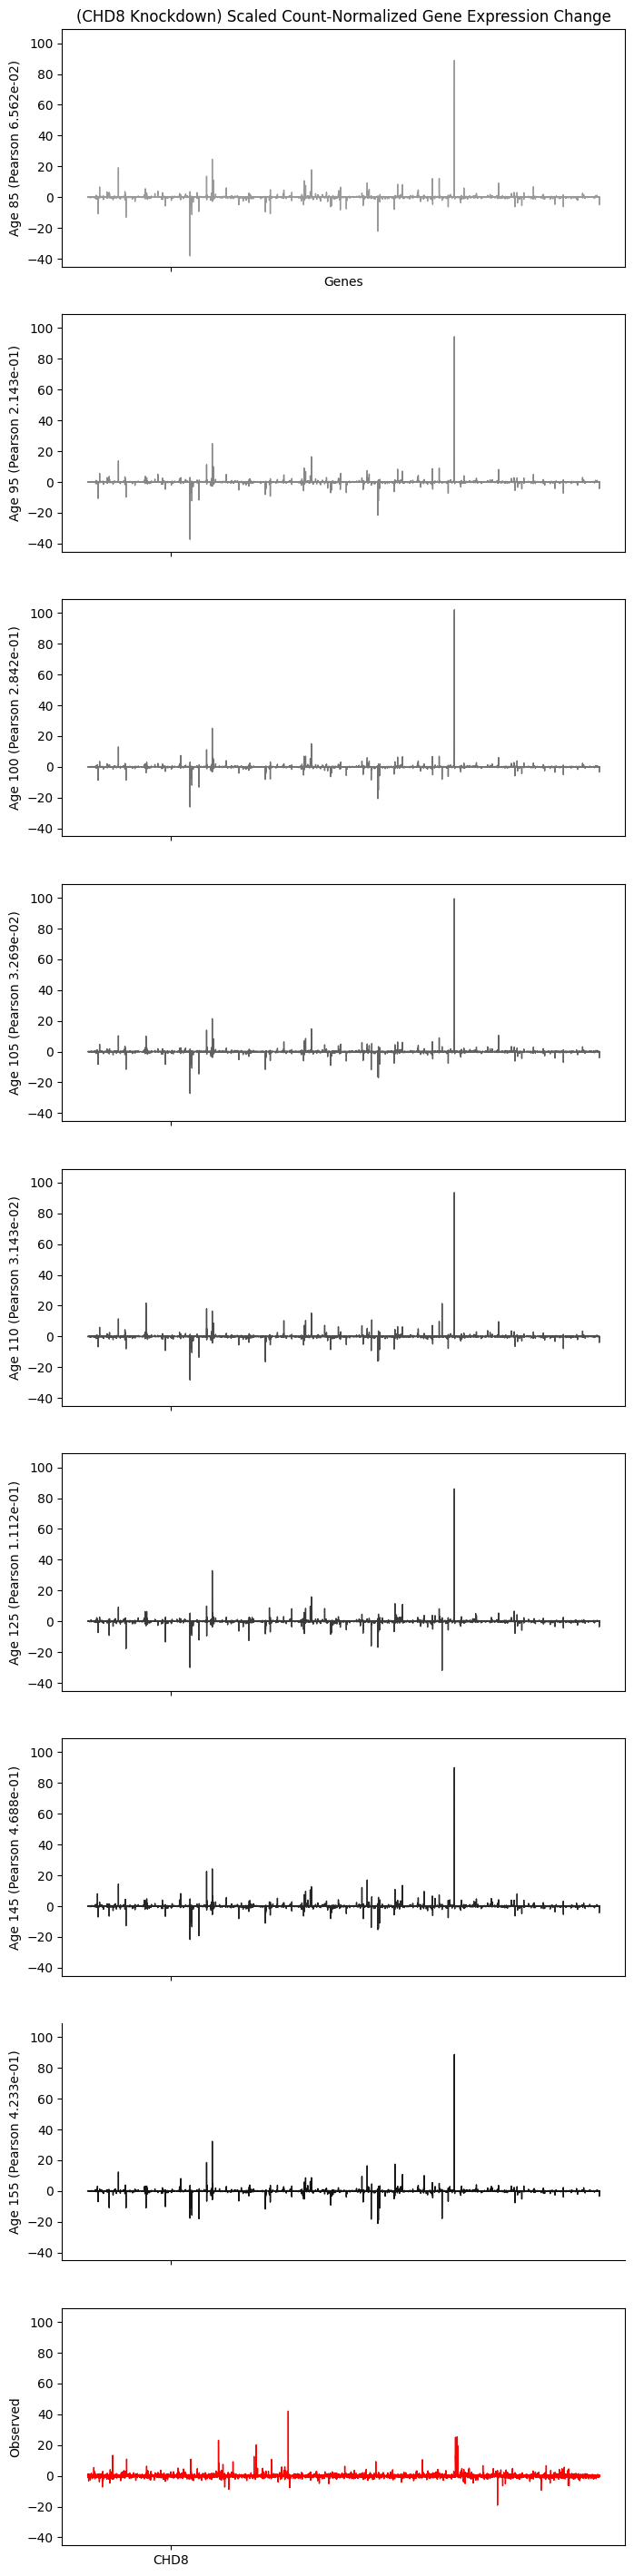

In [ ]:
# TODO: Perhaps plot in order of chromosome
# df = chd8_pert.melt(id_vars=['Age'], var_name='Gene', value_name='Change')
# df = df.loc[df['Gene'].isin(common_genes)]
# Create figure
num_ages = chd8_pert['Age'].unique().shape[0]
num_cols = num_ages + 1
age_colors = [tuple(3*[.6*i]) for i in np.arange(1, -1/num_ages, -1/num_ages)]
fig, axs = plt.subplots(num_cols, 1, figsize=(8, num_cols*4), sharex=True, sharey=True)
# Plot predictions
for ax, age, color in zip(axs, chd8_pert['Age'].unique(), age_colors):
    changes = chd8_pert.loc[chd8_pert['Age'] == age, common_genes].to_numpy().flatten()
    changes = changes * shchd8_diff[smart_common_idx].std() / changes.std()  # Scale changes, note this does not test CellTRIP scale
    top_genes = np.abs(shchd8_diff[smart_common_idx]).argsort()[::-1][:1000]
    # corr = np.corrcoef(changes[top_genes], shchd8_diff[smart_common_idx][top_genes])[0, 1]
    corr = scipy.stats.spearmanr(changes[top_genes], shchd8_diff[smart_common_idx][top_genes], alternative='greater')
    print(corr)
    ax.plot(np.arange(len(common_genes)), changes, lw=1, color=color, label=age)
    ax.set_ylabel(f'Age {age} (Pearson {corr.pvalue:.3e})')
# Plot reference
axs[-1].plot(np.arange(len(common_genes)), shchd8_diff[smart_common_idx], lw=1, color='red', label='Observed')
axs[-1].set_ylabel('Observed')
# Labels
axs[0].set(
    title='(CHD8 Knockdown) Scaled Count-Normalized Gene Expression Change',
    xlabel='Genes')  # ylabel='Scaled Count-Normalized Change'
# Ticks
genes_to_label = ['CHD8']
xticks = np.searchsorted(common_genes, genes_to_label)
axs[0].set(xticks=xticks, xticklabels=genes_to_label)
# Legend
# axs[0].legend(title='Age', ncols=2)
# Format
sns.despine(ax=ax)
# ax.set_yscale('symlog', linthresh=5.)
# Save
fig.savefig('../plots/expval/CHD8_validation.pdf')
fig.show()

In [120]:
# Create new manager
smart_manager = celltrip.manager.BasicManager(
    policy_fname=f'{prefix}-{training_step:04}.weights',
    preprocessing_fname=f'{prefix}.pre',
    mask_fname=f'{prefix}.mask',
    device='cuda')

In [ ]:
# Convert smart genes to adata genes
smart_genes_argsort = np.argsort(smart.var_names)
smart_to_adata_genes = smart_genes_argsort[np.searchsorted(smart.var_names, adata.var_names, sorter=smart_genes_argsort)]
common_gene_mask = np.isin(adata.var_names, smart.var_names)  # Takes time

# Put into adata
smart_adata = smart[:, smart_to_adata_genes].copy()
smart_adata.var_names = adata.var_names
smart_adata.X[:, ~common_gene_mask] = adata.X[:, ~common_gene_mask].mean(axis=0)

In [ ]:
# Set manager adata
# smart_manager.set_modalities([smart_adata], suppress_warning=True)

In [1]:
# Get adatas for control, perturbed, and ExN
cultured_adata = smart_adata[smart_adata.obs['acute_or_cultured']=='cultured_wo_virus_infection']
# cultured_adata = cultured_adata[cultured_adata.obs['subclass_prediction']=='ExN L3-5 IT']
shnc_adata = smart_adata[smart_adata.obs['acute_or_cultured']=='shNC']
# shnc_adata = shnc_adata[shnc_adata.obs['subclass_prediction']=='ExN L3-5 IT']
shchd8_adata = smart_adata[smart_adata.obs['acute_or_cultured']=='shCHD8']
# shchd8_adata = shchd8_adata[shchd8_adata.obs['subclass_prediction']=='ExN L3-5 IT']

# Simulate on shNC
smart_manager.set_modalities([shnc_adata], suppress_warning=True)
smart_manager.reset_env()
smart_manager.simulate(skip_time=512., impute=False, progress_bar=True)
smart_manager.save_state('steady')
steady_gex, = smart_manager.get_state()

# Get control
time, states = smart_manager.simulate_perturbation(skip_time=512., time=128., progress_bar=True)
control_gex, = smart_manager.get_state()

# Revert to previous state
smart_manager.load_state('steady')
smart_manager.clear_perturbations()

# Knock CHD8
gene = 'CHD8'
smart_manager.add_perturbation([gene], modality=0, feature_targets=0)
time, states = smart_manager.simulate_perturbation(skip_time=512., time=128., progress_bar=True, impute=False)
knocked_gex, = smart_manager.get_state()

# Revert to previous state
smart_manager.load_state('steady')
smart_manager.clear_perturbations()

NameError: name 'smart_adata' is not defined

In [ ]:
# Test that perturbation is reliable
max_deviation = np.square(control_gex - steady_gex).max()
mean_deviation = np.square(control_gex - steady_gex).mean()
print(f'Mean deviation: {mean_deviation:.2e}\nMax deviation: {max_deviation:.2e}\n')

# Get perturbation
shchd8_pert = (knocked_gex - steady_gex).mean(axis=0)

# Compute correlation
corr = scipy.stats.spearmanr(shchd8_pert[common_gene_mask], shchd8_diff[smart_to_adata_genes[common_gene_mask]], alternative='greater')  # shNC
# corr = scipy.stats.spearmanr(shchd8_pert[common_gene_mask], total_diff[smart_to_adata_genes[common_gene_mask]], alternative='greater')  # Cultured
print(f'Correlation: {corr.statistic:.3e}\np-value: {corr.pvalue:.3e}')

Mean deviation: 2.80e-10
Max deviation: 4.60e-05

Correlation: 5.112e-03
p-value: 2.622e-01


(0.0, 90.0)

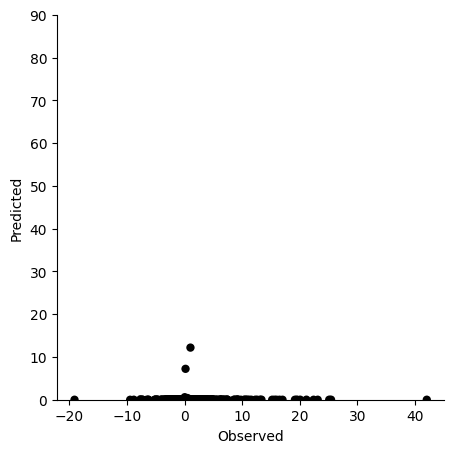

In [187]:
df = pd.DataFrame({'Observed': shchd8_diff[smart_to_adata_genes[common_gene_mask]], 'Predicted': shchd8_pert[common_gene_mask]})
# df = pd.DataFrame({'Observed': culture_means['shCHD8'][smart_to_adata_genes[common_gene_mask]], 'Predicted': knocked_gex.mean(axis=0)[common_gene_mask]})
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(df, x='Observed', y='Predicted', color='black', edgecolor='none', ax=ax)
sns.despine(ax=ax)
ax.set_ylim(0, 90)

## Visualize

In [ ]:
# # Params
# subtypes_to_use = [
#     'all', 'Astro EGFR', 'Endo Capillary', 'ExN L2-3 IT CUX2 BRINP3',
#     'ExN L3-5 IT RORB ILRAPL2', 'ExN L5 ET POU3F1 RGMA', 'ExN L6 B NR4A2 ARHGAP6',
#     'InN CGE ADARB2 CCK', 'InN MGE SOX6 BMPER', 'InN dLGE MEIS2 KCNK13',
#     'MG', 'OPC', 'OPC PS', 'Oligo', 'VLMC']

# # Get labels and data
# pert_filter = pert_results
# # pert_filter = pert_filter.loc[pert_results['Subtype'].isin(subtypes_to_use)]
# pert_filter = pert_filter.sort_values(sort_order)
# xlabels, x = np.unique(pert_filter['Identifier'], return_inverse=True)
# x, xlabels = pd.factorize(pert_filter['Identifier'])  # Factorize keeps order, as opposed to `np.unique(..., return_inverse=True)`
# xticks = list(range(len(xlabels)))
# y, ylabels = pd.factorize(pert_filter['Gene'])
# yticks = list(range(len(ylabels)))
# z, zlabels = pd.factorize(pert_filter['Subtype'])
# zticks = list(range(len(zlabels)))
# values = pert_filter['Control GES'].to_numpy()
# values = values/values.max()

# # Create figure
# fig = plt.figure(figsize=(8, 16))
# ax = fig.add_subplot(projection='3d')

# # Plot heatmap
# ax.scatter(
#     x, y, z, c=[(1-v)*np.array((160/256, 200/256, 220/256, .4))+v*np.array((220/256, 150/256, 100/256, 1.)) for v in values], lw=0,
#     depthshade=False,  # Incompatible with alpha
#     s=200*values)

# # Orienting lines
# # for _x, _y in itertools.product(xticks, yticks):
# #     ax.plot([_x, _x], [_y, _y], [0, len(zticks)-1], color='k', alpha=.3, lw=1)
# # for _x, _z in itertools.product(xticks, zticks):
# #     ax.plot([_x, _x], [0, len(yticks)-1], [_z, _z], color='k', alpha=.3, lw=1)
# # for _y, _z in itertools.product(yticks, zticks):
# #     ax.plot([0, len(xticks)-1], [_y, _y], [_z, _z], color='k', alpha=.3, lw=1)
# for i in np.argwhere(values > .7).flatten():
#     ax.plot([x[i], 0], [y[i], y[i]], [z[i], z[i]], color='k', alpha=.6, lw=1, zorder=0)
#     ax.plot([x[i], x[i]], [y[i], len(yticks)-1], [z[i], z[i]], color='k', alpha=.6, lw=1, zorder=0)
#     ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], 0], color='k', alpha=.6, lw=1, zorder=0)

# # Labels
# ax.set( 
#     xticks=xticks, xticklabels=xlabels,
#     yticks=yticks, yticklabels=ylabels,
#     zticks=zticks, zticklabels=zlabels)
# ax.set(xlim=[0, len(xticks)-1], ylim=[0, len(yticks)-1], zlim=[0, len(zticks)-1])

# # Save
# # ax.axis('off')
# fig.savefig('../plots/expval/heatmap.pdf')
# fig.show()

In [ ]:
# # Modified from https://python-graph-gallery.com/ridgeline-graph-seaborn/
# # Create grid
# pert_filter = pert_results
# # pert_filter = pert_filter.loc[pert_results['Subtype'].isin(subtypes_to_use)]  # Filter to select subtypes
# # pert_filter = pert_filter.loc[pert_filter['Gene']=='RAPGEF4']  # Filter to one gene
# pert_filter = pert_filter.copy().sort_values(['Subtype', 'Age', 'Sample'])  # Not the best sort
# subtype_gene_max = pert_filter.groupby(['Subtype', 'Gene'])['Control GES'].max()
# subtype_mean = pert_filter.groupby('Subtype')['Control GES'].mean()
# pert_filter['Subtype Gene Max Control GES'] = pert_filter[['Subtype', 'Gene']].apply(lambda x: subtype_gene_max[tuple(x)], axis=1).to_numpy()
# g = sns.FacetGrid(
#     pert_filter, row='Subtype', col='Gene', hue='Subtype Gene Max Control GES',
#     palette='coolwarm', aspect=15, height=0.75)
# # g.fig.patch.set_facecolor('None')
# for ax in g.axes.flat: ax.patch.set_facecolor('None')

# # Plot
# g.map(sns.lineplot, 'Identifier', 'Control GES', errorbar=None, color='white')
# def fillplot(*args, ax=None, alpha=1., **kwargs):
#     # Adapted from https://stackoverflow.com/a/77068597
#     if ax is None: ax = plt.gca()
#     for line in ax.lines:
#         x, y = line.get_xydata().T
#         ax.fill_between(x, 0, y, alpha=alpha, **kwargs)
# g.map(fillplot, 'Identifier', 'Control GES')

# # Labels and titles
# for (subtype, gene), ax in g.axes_dict.items():
#     is_first_gene = gene == pert_filter['Gene'].iloc[0]
#     is_first_subtype = subtype == pert_filter['Subtype'].iloc[0]
#     if is_first_gene:
#         ax.text(
#             -0.002, .002, subtype,
#             fontweight='bold', fontsize='large',
#             ha='right', va='bottom',
#             color='black',
#             transform=ax.transAxes)
#     if is_first_subtype:
#         ax.text(
#             .5, .5, gene,
#             fontweight='bold', fontsize='x-large',
#             ha='center', va='bottom',
#             color='black',
#             transform=ax.transAxes)
    
# # Remove extraneous formatting
# g.set_titles('')
# g.set(yticks=[], ylabel=None)
# g.despine(bottom=True, left=True)
# for ax in g.axes[:-1].flat: ax.tick_params(length=0)

# # Adjust
# g.set(ylim=(0, 1000))
# g.fig.subplots_adjust(hspace=-.8)
# g.fig.subplots_adjust(wspace=-.05)

# # Save
# g.fig.savefig('../plots/expval/effect_sizes.pdf')
# g.fig.show()

In [ ]:
# # Parameters
# traj_pairs = [
#     (3, 'RAPGEF4'),  #
#     (3, 'MEIS2'),
#     (3, 'NFIA'),
#     (3, 'NFIB'),
#     (3, 'CHD8'),
#     (3, 'MEIS2'),
#     (7, 'RAPGEF4'),
#     (7, 'MEIS2'),  #
#     (7, 'NFIA'),
#     (7, 'NFIB'),
#     (7, 'CHD8'),
#     (7, 'MEIS2'),
#     (10, 'RAPGEF4'),
#     (10, 'MEIS2'),
#     (10, 'NFIA'),  #
#     (10, 'NFIB'),
#     (10, 'CHD8'),
#     (10, 'MEIS2'),
# ]

# # Perturb
# trajectories = {}
# for traj_pair in traj_pairs:
#     # Split
#     sample, gene = traj_pair

#     # Filter adata
#     print(f'Testing {gene} on sample {sample}...')
#     adata_sample = adata[adata.obs['sample']==sample]
#     manager.set_modalities([adata_sample], suppress_warning=True)

#     # Simulate to steady state
#     manager.reset_env()
#     manager.simulate(skip_time=512., impute=False)
#     manager.save_state('steady')

#     # Perturb chosen gene
#     manager.add_perturbation([gene], modality=0, feature_targets=0)
#     time, states = manager.simulate_perturbation(skip_time=2., time=10., progress_bar=True)
#     trajectories[traj_pair] = (time, states[0])

In [ ]:
# # Lines
# for traj_pair in traj_pairs:
#     # Split
#     sample, gene = traj_pair
#     sample_obs = adata[adata.obs['sample']==sample].obs
#     sample_age = sample_obs['age'].iloc[0]

#     # Create figure
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#     # Get data
#     time, gex = trajectories[traj_pair]
#     gex_embed = red.transform(gex.reshape((-1, gex.shape[-1]))).reshape((*gex.shape[:-1], 2))

#     # Plot
#     subtypes = adata.obs['subtype'].unique()
#     palette = sns.color_palette(palette='husl', n_colors=len(subtypes))
#     for cell_i in range(gex_embed.shape[1]):
#         subtype = sample_obs['subtype'].iloc[cell_i]
#         ax.scatter(
#             *gex_embed[0, cell_i],
#             color=palette[(subtypes==subtype).argmax()],
#             label=subtype, s=2)
#         ax.plot(
#             *gex_embed[:, cell_i].T,
#             color=palette[(subtypes==subtype).argmax()],
#             alpha=.5, lw=.2)
#     ax.set_title(f'{gene} - {sample_age} ({sample})')
#     sns.despine(ax=ax)

#     # Save
#     fig.savefig(f'../plots/expval/{sample}_{gene}.pdf')


In [ ]:
# # Plot ct legend
# fig, ax = plt.subplots(1, 1)
# handles = [
#     plt.scatter(None, None, color=palette[(subtypes==subtype).argmax()], label=subtype)
#     for subtype in subtypes
# ]
# ax.legend(handles=handles)
# ax.axis('off');
# fig.savefig('../plots/expval/ct_legend.pdf')